In [ ]:
#Import Libraries

In [57]:
import pandas as pd
import random
from datetime import datetime, timedelta
import numpy as np
import joblib
import os

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import matplotlib.pyplot as plt
import streamlit as st
import dash
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

In [ ]:
#Create dummy data as a CSV file

In [64]:
#Constant columns
campuses = ['ASU_West', 'ASU_Downtown', 'ASU_Tempe', 'ASU_Poly']
daysOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
urgencyLevels = ['Low', 'Medium', 'High']
appointmentTypes = ['General Consultation', 'Follow-up', 'Urgent Care', 'Vaccination', 'Diagnostics']
rows = 40000

#Function for random dates from 2023 to 2024
def randWeekdays(start, end):
    while True:
        delta = end - start
        randomDays = random.randint(0, delta.days)
        randomDate = start + timedelta(days=randomDays)
        if randomDate.weekday() < 5:
            return randomDate
data = []
startDate = datetime(2023,1,1)
endDate = datetime(2024,12,31)

#For loop for data creation
for i in range(1, rows + 1):
    campus = random.choice(campuses)
    date = randWeekdays(startDate, endDate)
    time = (f"{random.randint(8,17)}:{random.randint(0,59):02d}")
    providerLoad = random.randint(1,15)
    clinicLoad = random.randint(1,200)
    appointmentType = random.choice(appointmentTypes)
    dayWeek = daysOfWeek[date.weekday()]
    noShow = round(random.uniform(0,30),2)
    urgency = random.choice(urgencyLevels)
    
    if 1 <= date.month <= 3:
        season = 'Winter'
    elif 4 <= date.month <= 6:
        season = 'Spring'
    elif 7 <= date.month <= 9:
        season = 'Summer'
    else:
        season = 'Fall'

    initialWait = ((providerLoad * 5) + (clinicLoad * 0.2))
    urgencyFactor = {'Low':0.8, 'Medium':1.0, 'High':1.5}[urgency]
    apptFactor = {'General Consultation':1.0, 'Follow-up':0.8, 'Urgent Care':1.5, 'Vaccination':0.5, 'Diagnostics':1.2}[appointmentType]
    waitTime = max(0, round((initialWait * urgencyFactor) + random.uniform(-10,10), 0))

    data.append([f"{i:05d}", campus, date.strftime('%Y-%m-%d'), time, providerLoad, clinicLoad, appointmentType, dayWeek, noShow, season, urgency, waitTime])

#Column names
columns = ['appointmentID', 'campus', 'date', 'time', 'providerLoad', 'clinicLoad', 'appointmentType', 'dayWeek', 'noShow', 'season', 'urgency', 'waitTime']

#Dataframe assignment and CSV write
df = pd.DataFrame(data, columns=columns)
df.to_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/dummy_patient_appointment_data.csv', index=False)

In [65]:
#Confirm dataset creation, print output
print("Dataset has been created and saved to the assigned path")
display(df)

Dataset has been created and saved to the assigned path


,appointmentID,campus,date,time,providerLoad,clinicLoad,appointmentType,dayWeek,noShow,season,urgency,waitTime
0,00001,ASU_Poly,2023-08-31,8:36,1,86,Diagnostics,Thursday,21.13,Summer,High,36.0
1,00002,ASU_West,2023-10-16,11:58,15,128,General Consultation,Monday,9.81,Fall,Low,77.0
2,00003,ASU_Downtown,2023-05-09,13:42,6,46,Diagnostics,Tuesday,0.08,Spring,Medium,32.0
3,00004,ASU_Tempe,2024-07-15,14:23,6,176,Diagnostics,Monday,1.95,Summer,Medium,58.0
4,00005,ASU_West,2023-11-29,17:45,1,31,Vaccination,Wednesday,9.98,Fall,High,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,ASU_Downtown,2024-03-05,8:33,9,84,Urgent Care,Tuesday,17.01,Winter,Medium,59.0
39996,39997,ASU_Tempe,2023-02-22,11:17,6,57,Follow-up,Wednesday,12.41,Winter,High,52.0
39997,39998,ASU_Downtown,2024-04-24,15:40,14,45,Diagnostics,Wednesday,7.10,Spring,Medium,79.0
39998,39999,ASU_Poly,2024-09-23,15:09,9,69,Urgent Care,Monday,5.37,Summer,Medium,51.0


In [ ]:
#Dataload

In [69]:
filepath = '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/dummy_patient_appointment_data.csv'
df = pd.read_csv(filepath)

print("Checking missing values")
if df.isnull().sum().sum() > 0:
    print("Missing values found")
    df.fillna(method='ffill', inplace=True)
else:
    print("No missing values")

Checking missing values
No missing values


In [ ]:
#Data pre-processing

In [70]:
#Encoding categorical values
categoricalColumns = ['campus', 'appointmentType', 'dayWeek', 'season', 'urgency']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encodedFeatures = encoder.fit_transform(df[categoricalColumns])
encodeddf = pd.DataFrame(encodedFeatures, columns=encoder.get_feature_names_out(categoricalColumns))

#Date and Time
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['Day'] = df['date'].dt.day
df['Month'] = df['date'].dt.month
df['Weekday'] = df['date'].dt.weekday
df['Weekend'] = (df['date'].dt.weekday >= 5).astype(int)

df['time'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce')
df['Hours'] = df['time'].dt.hour
df['Minute'] = df['time'].dt.minute
df['totalMins'] = ((df['Hours'] * 60) + df['Minute'])

#Drop irrelevant columns
df = df.drop('time', axis=1)
df = df.drop('date', axis=1)
df = df.drop(columns=['appointmentID'], errors='ignore')
df = df.drop(categoricalColumns, axis=1)
df = pd.concat([df, encodeddf], axis=1)
X = df.drop('waitTime', axis=1)
y = df['waitTime']

#Normalize data
numericalColumns = ['providerLoad', 'clinicLoad', 'noShow']
scaler = MinMaxScaler()
df[numericalColumns] = scaler.fit_transform(df[numericalColumns])

#Saving scaler & encoder files
joblib.dump(scaler, '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/Files/scaler.pkl')
joblib.dump(encoder, '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/Files/encoder.pkl')

#Fix feature sequence
finalFeatures = list(X.columns)
joblib.dump(finalFeatures, '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/Files/finalFeatures.pkl')

#Initiate training & testing varibales
print("Splitting dataset into training and testing sets")
fullData = pd.concat([X, y.reset_index(drop=True)], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Save data
preprocessedData = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test, 'scaler':scaler, 'encoder':encoder, 'finalFeature':finalFeatures}
print("Preprocessing complete")

#Confirm shape of dataset
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

#Saving new data
output = '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/processed_data'
os.makedirs(output, exist_ok=True)

fullData.to_csv(os.path.join(output, 'processedfile.csv'), index=False)

#Data combination
trainData = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
trainData.to_csv(os.path.join(output, "trainData.csv"), index=False)
print(f"Training data saved to {os.path.join(output, 'trainData.csv')}")
testData = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)
testData.to_csv(os.path.join(output, "testData.csv"), index=False)
print(f"Testing data saved to {os.path.join(output, 'testData.csv')}")

Splitting dataset into training and testing sets
Preprocessing complete
Training data shape: (32000, 31)
Testing data shape: (8000, 31)
Training data saved to /Users/rohitjoshi/University/Fall 2024/MFG 598/Project/processed_data/trainData.csv
Testing data saved to /Users/rohitjoshi/University/Fall 2024/MFG 598/Project/processed_data/testData.csv


In [38]:
#Preprocess data display
display(df)

,providerLoad,clinicLoad,noShow,waitTime,Day,Month,Weekday,Weekend,Hours,Minute,...,dayWeek_Thursday,dayWeek_Tuesday,dayWeek_Wednesday,season_Fall,season_Spring,season_Summer,season_Winter,urgency_High,urgency_Low,urgency_Medium
0,0.857143,0.638191,0.861667,134.0,29,3,4,0,11,45,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.000000,0.231156,0.314333,5.0,8,8,3,0,15,17,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.785714,0.829146,0.290333,65.0,9,10,0,0,12,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.214286,0.597990,0.970333,74.0,1,6,3,0,17,24,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.571429,0.819095,0.993667,76.0,13,9,4,0,8,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.714286,0.557789,0.883333,70.0,29,11,4,0,14,33,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39996,0.857143,0.884422,0.134667,95.0,13,3,2,0,16,12,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
39997,0.642857,0.773869,0.681000,82.0,31,10,3,0,16,16,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39998,0.285714,0.125628,0.737667,37.0,6,2,1,0,16,38,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
#Trainig and Testing ML models

In [ ]:
#Linear Regression


Linear Regression Results: 
Mean Absolute Error: 7.4484125708340345
Mean Squared Error: 86.25733768193736
Root Mean Squared Error: 9.287482849617401
R-squared: 0.9240849714286011

Linear Regression model saved


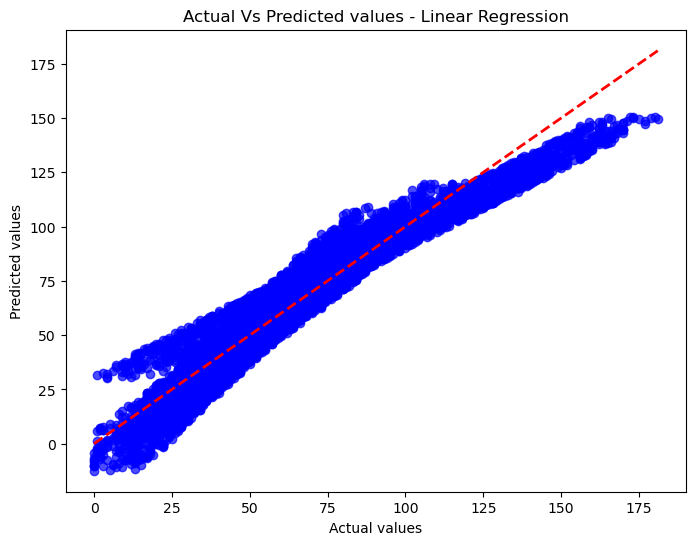

In [71]:
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
y_pred = linearModel.predict(X_test)

lrmae = mean_absolute_error(y_test, y_pred)
lrmse = mean_squared_error(y_test, y_pred)
lrrmse = np.sqrt(lrmse)
lrr2 = r2_score(y_test, y_pred)

#Display results
print("\nLinear Regression Results: ")
print(f"Mean Absolute Error: {lrmae}")
print(f"Mean Squared Error: {lrmse}")
print(f"Root Mean Squared Error: {lrrmse}")
print(f"R-squared: {lrr2}")

#Save trained model
joblib.dump(linearModel, '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Models/linear_regression.pkl')
print("\nLinear Regression model saved")

#Visualization
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual Vs Predicted values - Linear Regression")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.savefig("/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Plots/linear_regression_plot.png")
plt.show()

In [ ]:
#XGBoost


XGBoost Results: 
Mean Absolute Error: 5.160264904871583
Mean Squared Error: 36.73847930379488
Root Mean Squared Error: 6.061227541001482
R-squared: 0.9676664875016034

XGBoost model saved


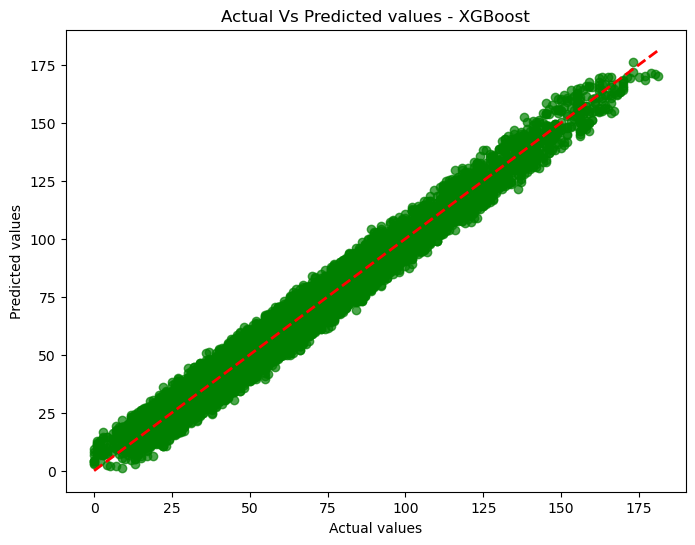

In [72]:
xgbModel = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgbModel.fit(X_train, y_train)
y_pred = xgbModel.predict(X_test)

xgmae = mean_absolute_error(y_test, y_pred)
xgmse = mean_squared_error(y_test, y_pred)
xgrmse = np.sqrt(xgmse)
xgr2 = r2_score(y_test, y_pred)

#Display results
print("\nXGBoost Results: ")
print(f"Mean Absolute Error: {xgmae}")
print(f"Mean Squared Error: {xgmse}")
print(f"Root Mean Squared Error: {xgrmse}")
print(f"R-squared: {xgr2}")

#Save trained model
joblib.dump(xgbModel, '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Models/xgboost.pkl')
print("\nXGBoost model saved")

#Visualization
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual Vs Predicted values - XGBoost")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.savefig("/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Plots/XGBoost_plot.png")
plt.show()

In [ ]:
#Random Forest


Random Forest Results: 
Mean Absolute Error: 5.186028749999999
Mean Squared Error: 37.0556158375
Root Mean Squared Error: 6.087332407343959
R-squared: 0.9673873758380134

Random Forest model saved


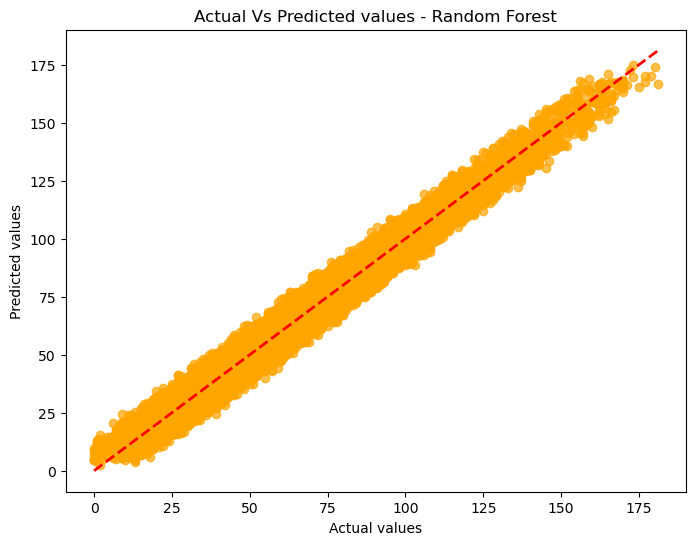

In [77]:
rfModel = RandomForestRegressor(n_estimators=100, random_state=42)
rfModel.fit(X_train, y_train)
y_pred = rfModel.predict(X_test)

rfmae = mean_absolute_error(y_test, y_pred)
rfmse = mean_squared_error(y_test, y_pred)
rfrmse = np.sqrt(rfmse)
rfr2 = r2_score(y_test, y_pred)

#Display results
print("\nRandom Forest Results: ")
print(f"Mean Absolute Error: {rfmae}")
print(f"Mean Squared Error: {rfmse}")
print(f"Root Mean Squared Error: {rfrmse}")
print(f"R-squared: {rfr2}")

#Save trained model
joblib.dump(rfModel, '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Models/random_forest.pkl')
print("\nRandom Forest model saved")

#Visualization
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual Vs Predicted values - Random Forest")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.savefig("/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Plots/random_forest_plot.png")
plt.show()

In [ ]:
#LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 30
[LightGBM] [Info] Start training from score 66.063281

Light GBM Results: 
Mean Absolute Error: 5.042079133010116
Mean Squared Error: 34.149903625432515
Root Mean Squared Error: 5.843791887587417
R-squared: 0.9699446913259171

LightGBM model saved


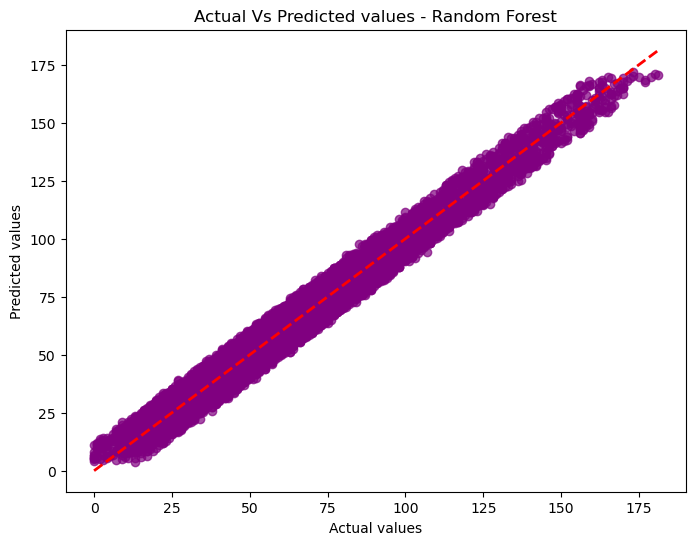

In [78]:
lgbModel = lgb.LGBMRegressor(objective='regression', metric='l2', random_state=42)
lgbModel.fit(X_train, y_train)
y_pred = lgbModel.predict(X_test)

lgbmae = mean_absolute_error(y_test, y_pred)
lgbmse = mean_squared_error(y_test, y_pred)
lgbrmse = np.sqrt(lgbmse)
lgbr2 = r2_score(y_test, y_pred)

#Display results
print("\nLight GBM Results: ")
print(f"Mean Absolute Error: {lgbmae}")
print(f"Mean Squared Error: {lgbmse}")
print(f"Root Mean Squared Error: {lgbrmse}")
print(f"R-squared: {lgbr2}")

#Save trained model
joblib.dump(lgbModel, '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Models/lightGBM.pkl')
print("\nLightGBM model saved")

#Visualization
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual Vs Predicted values - Random Forest")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.savefig("/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Plots/light_gbm_plot.png")
plt.show()

In [ ]:
#Compare performance metrics of all ML models

In [79]:
modelResults = {"Model": [], "MAE": [], "MSE": [], "RMSE": [], "R-squared": []}

def addResults(modelName, mae, mse, rmse, r2):
    modelResults["Model"].append(modelName)
    modelResults["MAE"].append(mae)
    modelResults["MSE"].append(mse)
    modelResults["RMSE"].append(rmse)
    modelResults["R-squared"].append(r2)

addResults("Linear Regression", lrmae, lrmse, lrrmse, lrr2)
addResults("XGBoost", xgmae, xgmse, xgrmse, xgr2)
addResults("Random Forest", rfmae, rfmse, rfrmse, rfr2)
addResults("Light GBM", lgbmae, lgbmse, lgbmse, lgbr2)

resultsdf = pd.DataFrame(modelResults)
print("Model performance comparison: ")
print(resultsdf)

Model performance comparison: 
               Model       MAE        MSE       RMSE  R-squared
0  Linear Regression  7.448413  86.257338   9.287483   0.924085
1            XGBoost  5.160265  36.738479   6.061228   0.967666
2      Random Forest  5.186029  37.055616   6.087332   0.967387
3          Light GBM  5.042079  34.149904  34.149904   0.969945


In [61]:
print(modelResults)

{'Model': ['Linear Regression', 'XGBoost', 'Random Forest', 'Light GBM'], 'MAE': [7.376677308493995, 5.13824996316433, 5.20360375, 5.020908025822679], 'MSE': [84.91990987784344, 36.57664646211423, 37.2376156375, 33.94387068109217], 'RMSE': [9.215199936943497, 6.04786296654564, 6.102263157018058, 33.94387068109217], 'R-squared': [0.9262902201975634, 0.9682517732235907, 0.9676780574431104, 0.9705370008382629]}


In [ ]:
#Recommend the best optimum model

In [80]:
modelScores = {}

for index, row in resultsdf.iterrows():
    modelName = row['Model']
    mae = row['MAE']
    mse = row['MSE']
    rmse = row['RMSE']
    r2 = row['R-squared']

#Score to predict best model with low error, high r-squared values
    modelScores[modelName] = {"MAE":mae, "MSE":mse, "RMSE":rmse, "R-squared":r2, "score":((mae+mse)-r2)}

bestModel = min(modelScores, key=lambda x:modelScores[x]["score"])

print("Modl Scores: ")
for model, scores in modelScores.items():
    print(f"{model} -> MAE: {scores['MAE']:2f}, MSE: {scores['MSE']:2f}, RMSE: {scores['RMSE']:2f}, R-squared: {scores['R-squared']:2f}, Score: {scores['score']:2f}")

print(f"\nRecommended model is {bestModel}, based on lowest error and highest R-squared value.")

Modl Scores: 
Linear Regression -> MAE: 7.448413, MSE: 86.257338, RMSE: 9.287483, R-squared: 0.924085, Score: 92.781665
XGBoost -> MAE: 5.160265, MSE: 36.738479, RMSE: 6.061228, R-squared: 0.967666, Score: 40.931078
Random Forest -> MAE: 5.186029, MSE: 37.055616, RMSE: 6.087332, R-squared: 0.967387, Score: 41.274257
Light GBM -> MAE: 5.042079, MSE: 34.149904, RMSE: 34.149904, R-squared: 0.969945, Score: 38.222038

Recommended model is Light GBM, based on lowest error and highest R-squared value.


In [ ]:
#Dashboard

In [ ]:
#Run the .py file using streamlit 'HealthQ_Dashboard'. This is provided here for reference.

In [ ]:
#import libraries as necessary
#Define databases and paths
df=pd.read_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/processed_data/processedfile.csv')
df2=pdf.read_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/dummy_patient_appointment_data.csv') 
df2['date'] = pd.to_datetime(df2['date'])
df3 = pdf.read_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/processed_data/testData.csv')
plots = '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Plots'

#Reiterate steps for ML training, Model performance metric comparison, and recommendation
#This has to be done in the .py file only because I want the dashboard to by dynamic.
#In case the original dataframe is changed, and a different model fits better, the test data should be trained on that instead of 
#hardcoding what we have right now.

#Dashboard

#Load dataset with caching
@st.cache_data
def dummyDataload():
    df2 = pd.read_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/dummy_patient_appointment_data.csv')
    df2['date'] = pd.to_datetime(df['date'])
    return df2

@st.cache_data
def testDataload():
    df3 = pd.read_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/processed_data/testData.csv')
    return df3

def modelandtools():
    encoder = joblib.load('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/Files/encoder.pkl')
    scaler = joblib.load('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/Files/scaler.pkl')
    features = joblib.load('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/Files/finalFeatures.pkl')
    models={"Linear Regresion": joblib.load('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Models/linear_regression.pkl'),
            "XGBoost": joblib.load('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Models/xgboost.pkl'),
            "Random Forest": joblib.load('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Models/random_forest.pkl'),
            "LightGBM": joblib.load('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Models/random_forest.pkl')}
    return encoder, scaler, features, models

plotDir = ('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Plots')
data = dummyDataload()
testData = testDataloatd()
encoder, scaler, features, models = modelandtools()


df = pd.read_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/processed_data/processedfile.csv')
df2 = pd.read_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/dummy_patient_appointment_data.csv') 
df2["date"] = pd.to_datetime(df2["date"])
df3 = pd.read_csv('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/processed_data/testData.csv') 
plot_directory = '/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ML Plots'

#Title
st.title("HealthQ Dashboard")

#Creating tabs
tabs = st.tabs(['About', 'Historical Trends', 'ML Model Comparison', 'Wait Time Prediction'])

#Tab0 - About 
with tabs[0]:
    st.header('About')
    st.image('/Users/rohitjoshi/University/Fall 2024/MFG 598/Project/ASU_Logo', width=200)
    st.markdown("""
    ##Welcome viewer!

    While working with ASU Campus Health Services, it was highlighted that patient wait times are a vital parameter that needs to be studied to provide better and faster service to the students. This metric also helps the leadership in planning and allocating resources as needed.
    Hence, I took on the task to devise a dashboard which will not only show patient appointment wait time trends, but also illustrate predicted wait time, based on user inputs.
    
    ###Project Overview:
    I took the following path for this project:
    1. **Data Creation**: Since actual data cannot be used due to HIPAA violation risk, I created a dummy data, covering all relevant fields which impact wait time.
    2. **Pre-Processing**: Once this was created, performed normalization, scaling, and encoding to ensure the dataset is in a standardized, and usable format.
    3. **Data Splitting**: Processed dataset was split as per 80-20 division for Training and Testing.
    4. **Model Training**: Trained 4 ML models - Linear Regression, XGBoost, Random Forest Regressor, LightGBM.
    5. **Performance Comparison**: Compared the performance of these models in a tabular form, along with graphs.
    6. **Recommendation**: Based on these metrics, recommendation was made for the optimal ML model to use for prediction in this case.
    7. **Dashboard Development**: Built this dashboard to showcase the following:
        -**Historical Trends** Helps to assess hisotrical trend of patient wait times for one of all campuses and a particular date range. 
        -**ML Model Comparison**: Displays performance metrics of all ML models trained with recommendation. Graph for actual vs predicted values for the recommended model is also shown.
        -**Prediction**: Dynamic, interactive dashboard which accepts user inputs and gives out predicted wait time for selected parameters.

    This application is designed to provide insights and empower leadership in improving clinic performance.

    ###Resource:
    You can explore the code and files for this project on [My Github Profile](https://github.com/rjoshi38).
    """)

#Tab1 - Historical Trends Section
with tabs[1]:
    st.header("Historical Wait Time Trends")
    campusOptions = ['All'] + list(df2['campus'].unique())
    campus = st.selectbox('Campus', campusOptions)
    
    startDate, endDate = st.date_input('Date Range', value=(df2['date'].min(), df2['date'].max()))
    filteredData = df2[(df2['date'] >= pd.to_datetime(startDate)) & (df2['date'] <= pd.to_datetime(endDate))]

    if campus != 'All':
        filteredData = filteredData[filteredData['campus'] == campus]
        
    filteredData['Wait Time'] = (filteredData['waitTime']/60)
    
    fig = px.bar(filteredData, x='date', y='waitTime', color='campus', title="Avg Wait Time by Campus (in mins)")
    st.plotly_chart(fig)

#Tab2 - ML Model Comparison Section
with tabs[2]:
    st.header("ML Model Comparison")
    resutlsdf = pd.DataFrame(modelResults) #recall ML performance metrics
    st.subheader("Model Performance Metrics")
    st.table(resultsdf)

    st.success(f"Recommended Model: {bestModel}") #recall recommendation

    bestModelMetrics = resultsdf[resultsdf['Model'] == bestModel].iloc[0]
    st.markdown(f"""
        ***Recommended Model Perf Metrics**:
        - **MAE**: {bestModelMetrics['MAE']:.2f}
        - **MSE**: {bestModelMetrics['MSE']:.2f}
        - **RMSE**: {bestModelMetrics['RMSE']:.2f}
        - **R2**: {bestModelMetrics['R-squared']:.2f}
        """)

    st.subheader(f"Actual Vs Predicted Values - {bestModel}") #Robust model with no hard coded recommendation
    plotFile = os.path.join(plotDir, f"{bestModel.lower().replace(' ', '_')}_plot.png")
    if os.path.exists(plotFile):
        st.image(plotFile, caption=f"Actual Vs Predicted - {bestModel}")
    else:
        st.error(f"Plot for {bestModel} missing")

#Tab3 - Predicted Wait Time Section
with tabs[3]:
    st.header("Wait Time Prediction")
    campusColumns = [col for col in df3.columns if col.startswith('campus_')]
    campusInput = st.selectbox('Campus', options = [col.replace('campus_','') for col in campusColumns])

    selDate = st.date_input('Date', value = pd.to_datetime('2023-01-1'))
    defaultTime = pd.Timestamp('08:00:00').time()
    selTime = st.time_input('Time', value = defaultTime)

    if selTime <pd.Timestamp('08:00:00').time() or selTime > pd.Timestamp('17:00:00').time():
        st.error('Time must be between 8am and 5pm')
    else:
        apptColumns = [col for col in df3.columns if col.startswith('appointmentType_')]
        apptTypeInput = st.selectbox('Appt Type', options=[col.replace('appointmentType_', '') for col in apptColumns])

        urgencyColumns = [col for col in df3.columns if col.startswith('urgency_')]
        urgencyInput = st.selectbox('Urgency', options=[col.replace('urgency_', '') for col in urgencyColumns])

        providerCount = st.slider('Provider Count', 1, 15, 5)
        clinicCount = st.slider('Clinic Load', 10, 200, 100)

        testData = testData.drop(columns=['waitTime'], errors='ignore')

        #using df3, testing dataset for prediction
        input_array = np.zeros(len(finalFeatures))
        for feature in finalFeatures:
            if f'campus_{campusInput}' in finalFeatures:
                input_array[finalFeatures.index(f'campus_{campusInput}')] = 1
            if f'appointmentType_{apptTypeInput}' in finalFeatures:
                input_array[finalFeatures.index(f'appointmentType_{apptTypeInput}')] = 1
            if f'urgency_{urgencyInput}' in finalFeatures:
                input_array[finalFeatures.index(f'urgency_{urgencyInput}')] = 1
        if 'providerLoad' in finalFeatures:
            input_array[finalFeatures.index(f'providerLoad')] = providerCount
        if 'clinicLoad' in finalFeatures:
            input_array[finalFeatures.index(f'clinicLoad')] = clinicCount

        recommendedModel = models[f'{bestModel}']
        predictedWaitTime = recommendedModel.predict([input_array])[0]
        st.success(f'Predicted Wait Time with selected conditions: {predictedWaitTime:.2f} mins')